This notebook contains all our scripts for the poster presentation at the NeuroAI Conference.

### Imports and Data Loading

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [ ]:
# stim_times: index at which stimulation occurred 
# ephys_array: array of Neurons_x_Samples (units = # of spikes) 
# img_array:  array of Neurons_x_Samples (units = dFF)
# stim_ID: Identity of a given stim (a = forward, b = reverse, c = random) 
# each index is 33ms

'''
3s after each stimulation, 100ms time bins
input summed dF/F
spikes 100ms

# 1 how well can we predict endogenous to endogenous: 3s after onset, -100 to +100 ms bins spikes as output.
    potential issue: Ca2+ decay issue! Temporal decorrelation by binarising at each onset time?
# 2 endogenous to stimulations: 30ms bins.

Off-target problems?
Recurrent networks?
'''

stim_time = np.load('./data/biological/stim_times.npy') # (300,)
ephys_array = np.load('./data/biological/ephys_array.npy') # (77, 94357)
img_array = np.load('./data/biological/img_array.npy') # (384, 94357)
stim_id = np.load('./data/biological/stim_ID.npy') # (300,)

n_neurons, total_time = ephys_array.shape
n_stims = stim_time.shape[0]

In [ ]:
from utils import rbf_rate_convolution_2d
ephys_rates = rbf_rate_convolution_2d(ephys_array.T, sigma=0.1).T # [94257, 77]

# pad
one_sided_padding_steps = int((total_time - ephys_rates.shape[0]) / 2)
one_sided_paddings = torch.zeros(one_sided_padding_steps, int(ephys_rates.shape[1]))
ephys_rates = torch.vstack((one_sided_paddings,ephys_rates))
ephys_rates = torch.vstack((ephys_rates, one_sided_paddings))

img_array = img_array.T

assert ephys_rates.shape[0] == total_time
assert img_array.shape[0] == ephys_rates.shape[0]

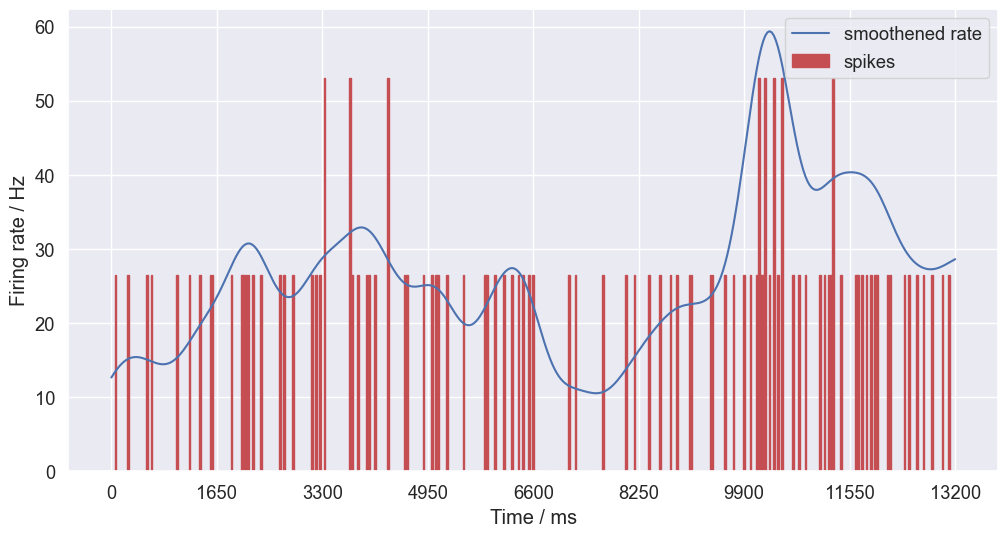

In [ ]:
# plot a sample of ephys smooth rates
plt.figure(figsize=(12,6))
plt.plot(ephys_rates[50000:50401,15], label='smoothened rate')
plt.xticks(np.arange(0,401,50), [i*33 for i in range(0, 401, 50)])
plt.bar(np.arange(401), height = ephys_array[15, 50000:50401] * ephys_rates[50000:50401,15].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

### Data Pre-processing
Process all input (GCaMP) data into independent tensors of length 15 (time steps) x 387 (input neurons) <br>
Process all output (EPhys) data into independent vectors of length 1 (time step) x 77 (output neurons)
The offset between input and output is -4 steps, found earlier by GLM. This is because there is a time delay in fluorescence decay.

In [5]:
tsteps = 15
cutoff_size = 2

assert ephys_rates.shape[0] == img_array.shape[0]

n_vecs = int(ephys_rates.shape[0] / tsteps)
input_dim = img_array.shape[1]
output_dim = ephys_rates.shape[1]
n_vecs = int(ephys_rates.shape[0]/tsteps)
n_stims = len(stim_time)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(ephys_rates)
img_array = torch.as_tensor(img_array)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])
non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [6]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

### Train for LS neurons only

In [7]:
# first 13 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[..., 0:13]
Y_test_LS = Y_test[..., 0:13]
output_dim = Y_train_LS.shape[-1]

batch_size = 4096
train_dataset = BNN_Dataset(X_train, Y_train_LS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
# valid_dataset = BNN_Dataset(X_valid, Y_valid_LS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Hyperparameter optimisation for transformer using Bayes Opt: <br>
<ol>
  <li>d_model (int) – the number of expected features in the input (required).</li>
  <li>nhead (int) – the number of heads in the multiheadattention models (required).</li>
  <li>hidden_dim (int) – the dimension of the feedforward network model (default=2048).</li>
  <li>num_layers – the number of sub-encoder-layers in the encoder (required).</li>
</ol>

In [21]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)


    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=valid_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:59<00:00,  2.09it/s]


| 1         | -185.5    | 475.3     | 748.3     | 1.0       | 6.744     |


100%|██████████| 250/250 [01:28<00:00,  2.82it/s]


| 2         | -188.0    | 232.1     | 183.1     | 1.745     | 7.566     |


100%|██████████| 250/250 [02:52<00:00,  1.45it/s]


| 3         | -185.8    | 457.1     | 584.9     | 2.677     | 14.02     |


100%|██████████| 250/250 [01:46<00:00,  2.34it/s]


| 4         | -180.4    | 284.0     | 890.3     | 1.11      | 13.74     |


100%|██████████| 250/250 [01:53<00:00,  2.19it/s]


| 5         | -190.0    | 475.6     | 602.8     | 1.562     | 4.764     |


100%|██████████| 250/250 [04:25<00:00,  1.06s/it]


| 6         | -211.6    | 820.7     | 971.4     | 2.254     | 14.15     |


100%|██████████| 250/250 [02:59<00:00,  1.40it/s]


| 7         | -197.8    | 888.8     | 905.1     | 1.34      | 1.742     |


100%|██████████| 250/250 [01:41<00:00,  2.46it/s]


| 8         | -179.2    | 252.8     | 890.3     | 1.393     | 9.001     |


100%|██████████| 250/250 [06:41<00:00,  1.60s/it]


| 9         | -209.7    | 962.1     | 579.8     | 3.768     | 6.995     |


100%|██████████| 250/250 [02:45<00:00,  1.51it/s]


| 10        | -191.8    | 717.9     | 851.2     | 1.073     | 15.25     |


100%|██████████| 250/250 [05:05<00:00,  1.22s/it]


| 11        | -203.7    | 990.0     | 773.3     | 2.122     | 16.0      |


100%|██████████| 250/250 [02:27<00:00,  1.69it/s]


| 12        | -172.6    | 192.9     | 503.1     | 4.634     | 6.579     |


100%|██████████| 250/250 [01:44<00:00,  2.38it/s]


| 13        | -188.3    | 359.0     | 217.0     | 1.077     | 13.9      |


100%|██████████| 250/250 [01:57<00:00,  2.12it/s]


| 14        | -175.0    | 290.5     | 339.0     | 2.966     | 2.014     |


100%|██████████| 250/250 [04:15<00:00,  1.02s/it]


| 15        | -296.8    | 616.7     | 232.1     | 3.357     | 14.3      |


100%|██████████| 250/250 [02:16<00:00,  1.83it/s]


| 16        | -181.9    | 192.1     | 472.7     | 3.778     | 8.869     |


100%|██████████| 250/250 [02:04<00:00,  2.00it/s]


| 17        | -187.1    | 145.0     | 582.3     | 3.655     | 10.78     |


100%|██████████| 250/250 [07:23<00:00,  1.78s/it]


| 18        | -299.4    | 950.1     | 627.9     | 4.614     | 3.612     |


100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


| 19        | -175.5    | 225.3     | 826.7     | 2.591     | 4.142     |


100%|██████████| 250/250 [06:47<00:00,  1.63s/it]


| 20        | -299.4    | 934.8     | 413.0     | 4.003     | 14.79     |


100%|██████████| 250/250 [07:08<00:00,  1.71s/it]


| 21        | -299.6    | 895.0     | 661.3     | 4.004     | 7.629     |


100%|██████████| 250/250 [02:28<00:00,  1.68it/s]


| 22        | -173.4    | 342.9     | 906.3     | 2.712     | 19.33     |


100%|██████████| 250/250 [02:31<00:00,  1.66it/s]


| 23        | -182.6    | 697.1     | 659.5     | 1.459     | 19.04     |


100%|██████████| 250/250 [02:45<00:00,  1.51it/s]


| 24        | -186.9    | 504.9     | 620.6     | 2.633     | 5.504     |


100%|██████████| 250/250 [03:00<00:00,  1.38it/s]


| 25        | -186.6    | 913.0     | 616.3     | 1.011     | 12.73     |


100%|██████████| 250/250 [03:30<00:00,  1.19it/s]


| 26        | -299.7    | 394.0     | 574.4     | 4.544     | 7.788     |


100%|██████████| 250/250 [02:48<00:00,  1.48it/s]


| 27        | -186.9    | 917.7     | 661.0     | 1.063     | 18.66     |


100%|██████████| 250/250 [02:29<00:00,  1.67it/s]


| 28        | -191.6    | 721.8     | 997.6     | 1.689     | 3.606     |


100%|██████████| 250/250 [02:51<00:00,  1.46it/s]


| 29        | -187.6    | 939.3     | 727.1     | 1.264     | 15.35     |


100%|██████████| 250/250 [05:29<00:00,  1.32s/it]


| 30        | -242.2    | 778.5     | 930.7     | 3.846     | 3.361     |


100%|██████████| 250/250 [01:19<00:00,  3.14it/s]


| 31        | -205.8    | 117.9     | 123.6     | 1.113     | 5.678     |


100%|██████████| 250/250 [05:16<00:00,  1.27s/it]


| 32        | -320.6    | 874.0     | 584.9     | 3.211     | 17.0      |


100%|██████████| 250/250 [02:40<00:00,  1.55it/s]


| 33        | -170.8    | 211.8     | 351.3     | 3.343     | 19.42     |


100%|██████████| 250/250 [04:23<00:00,  1.05s/it]


| 34        | -300.0    | 604.9     | 116.8     | 4.203     | 5.427     |


100%|██████████| 250/250 [06:38<00:00,  1.59s/it]


| 35        | -299.4    | 826.4     | 449.1     | 4.454     | 15.2      |


100%|██████████| 250/250 [02:00<00:00,  2.08it/s]


| 36        | -195.5    | 600.6     | 222.8     | 1.24      | 3.306     |


100%|██████████| 250/250 [01:23<00:00,  2.98it/s]


| 37        | -195.2    | 140.1     | 196.7     | 1.903     | 14.55     |


100%|██████████| 250/250 [02:06<00:00,  1.98it/s]


| 38        | -187.4    | 603.7     | 111.3     | 1.288     | 19.38     |


100%|██████████| 250/250 [03:05<00:00,  1.35it/s]


| 39        | -197.4    | 611.3     | 283.0     | 2.009     | 15.13     |


100%|██████████| 250/250 [03:29<00:00,  1.19it/s]


| 40        | -168.7    | 275.9     | 623.2     | 4.88      | 17.09     |


100%|██████████| 250/250 [02:37<00:00,  1.59it/s]


| 41        | -171.4    | 315.9     | 544.4     | 3.48      | 16.75     |


100%|██████████| 250/250 [01:29<00:00,  2.79it/s]


| 42        | -185.8    | 241.1     | 116.7     | 1.28      | 10.24     |


100%|██████████| 250/250 [03:20<00:00,  1.24it/s]


| 43        | -200.1    | 645.7     | 612.0     | 2.269     | 19.78     |


100%|██████████| 250/250 [03:38<00:00,  1.15it/s]


| 44        | -299.4    | 621.8     | 442.1     | 3.204     | 15.16     |


100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


| 45        | -189.5    | 702.3     | 338.4     | 1.265     | 8.032     |


100%|██████████| 250/250 [03:09<00:00,  1.32it/s]


| 46        | -299.7    | 666.7     | 289.2     | 4.011     | 2.264     |


100%|██████████| 250/250 [01:38<00:00,  2.55it/s]


| 47        | -184.5    | 334.3     | 824.3     | 1.774     | 13.15     |


100%|██████████| 250/250 [02:16<00:00,  1.83it/s]


| 48        | -191.9    | 572.2     | 932.3     | 2.053     | 2.253     |


100%|██████████| 250/250 [03:53<00:00,  1.07it/s]


| 49        | -299.4    | 761.6     | 795.0     | 4.631     | 18.71     |


100%|██████████| 250/250 [01:39<00:00,  2.52it/s]


| 50        | -198.3    | 112.6     | 310.9     | 3.467     | 19.03     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:46<00:00,  2.34it/s]


| 51        | -187.2    | 696.1     | 658.4     | 1.516     | 18.39     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


| 52        | -179.3    | 270.0     | 630.6     | 3.881     | 11.3      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:27<00:00,  2.85it/s]
c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


| 53        | -180.8    | 200.8     | 492.6     | 2.29      | 8.167     |


100%|██████████| 250/250 [01:27<00:00,  2.85it/s]


| 54        | -191.1    | 183.6     | 488.8     | 1.883     | 14.12     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:00<00:00,  2.07it/s]


| 55        | -177.7    | 278.9     | 620.8     | 2.308     | 3.815     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:54<00:00,  2.19it/s]


| 56        | -176.4    | 270.1     | 894.7     | 2.446     | 1.132     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:47<00:00,  1.49it/s]


| 57        | -164.1    | 270.0     | 876.5     | 3.016     | 16.14     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:00<00:00,  1.38it/s]


| 58        | -165.7    | 269.6     | 899.1     | 4.02      | 18.84     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:14<00:00,  1.28it/s]


| 59        | -169.7    | 248.4     | 865.5     | 4.098     | 15.59     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:10<00:00,  1.92it/s]


| 60        | -182.0    | 264.8     | 856.8     | 2.174     | 11.99     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


| 61        | -173.3    | 236.8     | 846.3     | 2.076     | 3.327     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:26<00:00,  1.21it/s]


| 62        | -163.6    | 221.1     | 848.9     | 5.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:06<00:00,  1.98it/s]


| 63        | -174.4    | 219.1     | 865.5     | 3.816     | 3.937     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:19<00:00,  1.80it/s]


| 64        | -188.1    | 714.8     | 680.8     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:31<00:00,  2.72it/s]


| 65        | -187.3    | 197.7     | 845.9     | 1.059     | 14.94     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:26<00:00,  1.70it/s]


| 66        | -172.7    | 255.4     | 604.8     | 3.545     | 18.99     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:34<00:00,  1.62it/s]


| 67        | -172.8    | 272.8     | 581.6     | 3.438     | 11.93     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:38<00:00,  2.53it/s]


| 68        | -184.2    | 291.8     | 598.8     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:16<00:00,  1.27it/s]


| 69        | -171.7    | 301.1     | 567.0     | 4.809     | 13.08     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:38<00:00,  2.54it/s]


| 70        | -183.0    | 284.7     | 545.3     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:22<00:00,  1.76it/s]


| 71        | -177.1    | 242.1     | 346.5     | 3.198     | 12.72     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:02<00:00,  2.03it/s]


| 72        | -175.3    | 224.5     | 319.5     | 3.336     | 10.6      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:13<00:00,  1.87it/s]


| 73        | -169.8    | 197.4     | 333.3     | 5.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:02<00:00,  2.05it/s]


| 74        | -164.9    | 262.2     | 320.3     | 3.99      | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:43<00:00,  1.52it/s]


| 75        | -177.8    | 279.6     | 317.6     | 3.305     | 17.9      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:26<00:00,  2.89it/s]


| 76        | -185.7    | 251.9     | 292.8     | 1.0       | 8.794     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:21<00:00,  3.06it/s]


| 77        | -193.1    | 188.7     | 364.6     | 1.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


| 78        | -195.5    | 573.3     | 209.3     | 1.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:56<00:00,  1.42it/s]


| 79        | -169.6    | 338.6     | 872.2     | 3.354     | 18.13     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:43<00:00,  1.53it/s]


| 80        | -164.5    | 361.0     | 882.3     | 3.798     | 1.135     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:39<00:00,  2.51it/s]


| 81        | -193.7    | 358.7     | 854.9     | 1.663     | 2.853     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:45<00:00,  2.37it/s]


| 82        | -186.2    | 372.4     | 903.8     | 1.252     | 10.64     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:14<00:00,  1.86it/s]


| 83        | -179.6    | 177.8     | 316.3     | 3.307     | 19.3      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:21<00:00,  3.07it/s]


| 84        | -201.5    | 199.5     | 295.2     | 1.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [03:35<00:00,  1.16it/s]


| 85        | -299.4    | 328.9     | 890.5     | 5.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:47<00:00,  2.32it/s]


| 86        | -185.0    | 361.4     | 878.6     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:52<00:00,  2.21it/s]


| 87        | -178.1    | 266.8     | 342.4     | 2.662     | 9.407     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:55<00:00,  1.43it/s]


| 88        | -169.9    | 185.5     | 342.3     | 5.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:46<00:00,  2.34it/s]


| 89        | -187.4    | 327.4     | 853.0     | 1.678     | 19.8      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


| 90        | -188.4    | 351.7     | 931.1     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:02<00:00,  2.04it/s]


| 91        | -174.3    | 243.3     | 578.4     | 3.597     | 2.559     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:37<00:00,  1.59it/s]


| 92        | -170.7    | 250.4     | 553.6     | 3.542     | 19.01     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:35<00:00,  1.60it/s]


| 93        | -167.5    | 224.4     | 539.2     | 4.087     | 8.22      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:44<00:00,  1.52it/s]


| 94        | -172.6    | 220.4     | 569.1     | 3.781     | 19.24     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:37<00:00,  1.59it/s]


| 95        | -174.8    | 197.3     | 545.2     | 3.589     | 17.65     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:04<00:00,  2.01it/s]


| 96        | -171.3    | 252.0     | 526.2     | 3.232     | 1.469     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:44<00:00,  1.52it/s]


| 97        | -176.4    | 223.5     | 515.6     | 3.053     | 19.39     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:36<00:00,  2.58it/s]


| 98        | -179.1    | 189.1     | 574.1     | 2.558     | 4.556     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [02:01<00:00,  2.06it/s]


| 99        | -177.2    | 173.9     | 527.5     | 4.728     | 1.489     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [01:54<00:00,  2.18it/s]

| 100       | -182.7    | 212.8     | 608.7     | 2.555     | 14.42     |


Train transformer

In [8]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 62        | -163.6    | 221.1     | 848.9     | 5.0       | 20.0      |
# | 57        | -164.1    | 270.0     | 876.5     | 3.016     | 16.14     |


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_LS = TransformerDNN(input_dim=input_dim,
                    d_model=220,
                    num_heads=20,
                    hidden_dim=848,
                    output_dim=output_dim,
                    n_layers=5,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_LS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cngzlsh. Use `wandb login --relogin` to force relogin


100%|██████████| 500/500 [04:33<00:00,  1.83it/s]


In [10]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': 220,
                    'num_heads': 20,
                    'hidden_dim': 848,
                    'output_dim': output_dim,
                    'n_layers': 5,
                    'num_epochs': num_epochs},
        'train_data': return_dict}

with open(f'./data/biological/trained_models/LS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/LS-transformer-param.pkl')

Saved model parameters and training stats to ./data/biological/trained_models/LS-transformer-param.pkl


Load best model parameters and show test losses

In [10]:
# with open('./data/biological/trained_models/LS-transformer-param.pkl', 'rb') as f:
#     data = pickle.load(f)
#     f.close()
# return_dict = data['train_data']
    
DNN_LS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,:13])
    print(LS_test_pred_loss.sum()/500/13)
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/13)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/13)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/13)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13)

tensor(162.7316)
Transformer prediction for forward stim MSE loss:  tensor(149.5830)
Transformer prediction for backward stim MSE loss:  tensor(166.1236)
Transformer prediction for random stim MSE loss:  tensor(157.7335)
Transformer prediction for non-stim stim MSE loss:  tensor(170.1892)


As a comparison, train GLM on each output neuron and show test losses

In [14]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])
output_dim = Y_test_LS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    
glm_loss = glm_LS_losses.sum() / Y_test_LS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

100%|██████████| 13/13 [04:17<00:00, 19.84s/it]

GLM with identity function loss:  203.74170461933716
GLM prediction for forward stim R2 loss:  199.0227219687733
GLM prediction for backward stim R2 loss:  202.1396938812515
GLM prediction for random stim R2 loss:  223.59592263523402
GLM prediction for non-stim stim R2 loss:  197.45097145948037


### Train for non-LS neurons only

In [15]:
Y_train_nLS = Y_train[..., 13:]
Y_test_nLS = Y_test[..., 13:]
# Y_valid_nLS = Y_valid[..., 13:]
output_dim = Y_train_nLS.shape[-1]

batch_size = 2048
train_dataset = BNN_Dataset(X_train, Y_train_nLS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

# valid_dataset = BNN_Dataset(X_valid, Y_valid_nLS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Hyperparameter optimisation for transformer using Bayes Opt

In [23]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=test_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=500,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [03:28<00:00,  2.40it/s]


| 1         | -269.1    | 475.3     | 748.3     | 1.0       | 6.744     |


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


| 2         | -332.0    | 232.1     | 183.1     | 1.745     | 7.566     |


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


| 3         | -263.3    | 457.1     | 584.9     | 2.677     | 14.02     |


100%|██████████| 500/500 [03:08<00:00,  2.65it/s]


| 4         | -310.4    | 284.0     | 890.3     | 1.11      | 13.74     |


100%|██████████| 500/500 [03:20<00:00,  2.49it/s]


| 5         | -267.3    | 475.6     | 602.8     | 1.562     | 4.764     |


100%|██████████| 500/500 [08:13<00:00,  1.01it/s]


| 6         | -242.3    | 820.7     | 971.4     | 2.254     | 14.15     |


100%|██████████| 500/500 [05:31<00:00,  1.51it/s]


| 7         | -249.5    | 888.8     | 905.1     | 1.34      | 1.742     |


100%|██████████| 500/500 [02:59<00:00,  2.78it/s]


| 8         | -324.2    | 252.8     | 890.3     | 1.393     | 9.001     |


100%|██████████| 500/500 [12:24<00:00,  1.49s/it]


| 9         | -254.8    | 962.1     | 579.8     | 3.768     | 6.995     |


100%|██████████| 500/500 [04:48<00:00,  1.73it/s]


| 10        | -248.4    | 717.9     | 851.2     | 1.073     | 15.25     |


100%|██████████| 500/500 [09:34<00:00,  1.15s/it]


| 11        | -268.0    | 990.0     | 773.3     | 2.122     | 16.0      |


100%|██████████| 500/500 [04:32<00:00,  1.84it/s]


| 12        | -372.4    | 192.9     | 503.1     | 4.634     | 6.579     |


100%|██████████| 500/500 [03:15<00:00,  2.55it/s]


| 13        | -286.0    | 359.0     | 217.0     | 1.077     | 13.9      |


100%|██████████| 500/500 [03:28<00:00,  2.40it/s]


| 14        | -305.2    | 290.5     | 339.0     | 2.966     | 2.014     |


100%|██████████| 500/500 [07:53<00:00,  1.06it/s]


| 15        | -247.7    | 616.7     | 232.1     | 3.357     | 14.3      |


100%|██████████| 500/500 [04:07<00:00,  2.02it/s]


| 16        | -366.9    | 192.1     | 472.7     | 3.778     | 8.869     |


100%|██████████| 500/500 [03:43<00:00,  2.24it/s]


| 17        | -417.9    | 145.0     | 582.3     | 3.655     | 10.78     |


100%|██████████| 500/500 [15:14<00:00,  1.83s/it]


| 18        | -324.0    | 950.1     | 627.9     | 4.614     | 3.612     |


100%|██████████| 500/500 [03:28<00:00,  2.39it/s]


| 19        | -336.5    | 225.3     | 826.7     | 2.591     | 4.142     |


100%|██████████| 500/500 [13:55<00:00,  1.67s/it]


| 20        | -321.8    | 934.8     | 413.0     | 4.003     | 14.79     |


100%|██████████| 500/500 [14:45<00:00,  1.77s/it]


| 21        | -293.8    | 895.0     | 661.3     | 4.004     | 7.629     |


100%|██████████| 500/500 [04:39<00:00,  1.79it/s]


| 22        | -289.5    | 342.9     | 906.3     | 2.712     | 19.33     |


100%|██████████| 500/500 [04:50<00:00,  1.72it/s]


| 23        | -245.7    | 697.1     | 659.5     | 1.459     | 19.04     |


100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


| 24        | -259.8    | 504.9     | 620.6     | 2.633     | 5.504     |


100%|██████████| 500/500 [06:01<00:00,  1.38it/s]


| 25        | -245.4    | 913.0     | 616.3     | 1.011     | 12.73     |


100%|██████████| 500/500 [07:03<00:00,  1.18it/s]


| 26        | -275.5    | 394.0     | 574.4     | 4.544     | 7.788     |


100%|██████████| 500/500 [05:35<00:00,  1.49it/s]


| 27        | -248.3    | 917.7     | 661.0     | 1.063     | 18.66     |


100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


| 28        | -247.9    | 721.8     | 997.6     | 1.689     | 3.606     |


100%|██████████| 500/500 [05:42<00:00,  1.46it/s]


| 29        | -246.5    | 939.3     | 727.1     | 1.264     | 15.35     |


100%|██████████| 500/500 [11:09<00:00,  1.34s/it]


| 30        | -249.0    | 778.5     | 930.7     | 3.846     | 3.361     |


100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


| 31        | -453.3    | 117.9     | 123.6     | 1.113     | 5.678     |


100%|██████████| 500/500 [10:42<00:00,  1.29s/it]


| 32        | -254.4    | 874.0     | 584.9     | 3.211     | 17.0      |


100%|██████████| 500/500 [05:16<00:00,  1.58it/s]


| 33        | -334.6    | 211.8     | 351.3     | 3.343     | 19.42     |


100%|██████████| 500/500 [08:48<00:00,  1.06s/it]


| 34        | -259.2    | 604.9     | 116.8     | 4.203     | 5.427     |


100%|██████████| 500/500 [13:29<00:00,  1.62s/it]


| 35        | -269.1    | 826.4     | 449.1     | 4.454     | 15.2      |


100%|██████████| 500/500 [03:46<00:00,  2.21it/s]


| 36        | -253.9    | 600.6     | 222.8     | 1.24      | 3.306     |


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


| 37        | -418.8    | 140.1     | 196.7     | 1.903     | 14.55     |


100%|██████████| 500/500 [04:02<00:00,  2.06it/s]


| 38        | -258.7    | 603.7     | 111.3     | 1.288     | 19.38     |


100%|██████████| 500/500 [06:11<00:00,  1.35it/s]


| 39        | -253.2    | 611.3     | 283.0     | 2.009     | 15.13     |


100%|██████████| 500/500 [07:05<00:00,  1.18it/s]


| 40        | -311.9    | 275.9     | 623.2     | 4.88      | 17.09     |


100%|██████████| 500/500 [05:03<00:00,  1.65it/s]


| 41        | -299.7    | 315.9     | 544.4     | 3.48      | 16.75     |


100%|██████████| 500/500 [02:50<00:00,  2.94it/s]


| 42        | -330.5    | 241.1     | 116.7     | 1.28      | 10.24     |


100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


| 43        | -245.7    | 645.7     | 612.0     | 2.269     | 19.78     |


100%|██████████| 500/500 [07:45<00:00,  1.07it/s]


| 44        | -253.7    | 621.8     | 442.1     | 3.204     | 15.16     |


100%|██████████| 500/500 [04:04<00:00,  2.04it/s]


| 45        | -253.0    | 702.3     | 338.4     | 1.265     | 8.032     |


100%|██████████| 500/500 [09:15<00:00,  1.11s/it]


| 46        | -260.4    | 666.7     | 289.2     | 4.011     | 2.264     |


100%|██████████| 500/500 [03:14<00:00,  2.57it/s]


| 47        | -293.5    | 334.3     | 824.3     | 1.774     | 13.15     |


100%|██████████| 500/500 [05:50<00:00,  1.43it/s]


| 48        | -252.7    | 572.2     | 932.3     | 2.053     | 2.253     |


100%|██████████| 500/500 [12:16<00:00,  1.47s/it]


| 49        | -286.5    | 761.6     | 795.0     | 4.631     | 18.71     |


100%|██████████| 500/500 [03:55<00:00,  2.13it/s]
c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


| 50        | -464.4    | 112.6     | 310.9     | 3.467     | 19.03     |


100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


| 51        | -250.6    | 696.1     | 658.4     | 1.516     | 18.39     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:35<00:00,  1.82it/s]


| 52        | -248.2    | 718.1     | 713.7     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


| 53        | -247.3    | 755.2     | 661.0     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [05:57<00:00,  1.40it/s]


| 54        | -249.4    | 592.8     | 556.7     | 2.164     | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


| 55        | -250.8    | 667.1     | 924.5     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [05:32<00:00,  1.50it/s]


| 56        | -248.7    | 927.0     | 529.9     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [06:55<00:00,  1.20it/s]


| 57        | -246.2    | 683.0     | 521.7     | 2.866     | 13.87     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [10:55<00:00,  1.31s/it]


| 58        | -288.4    | 718.5     | 437.5     | 4.454     | 17.51     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [06:50<00:00,  1.22it/s]


| 59        | -244.6    | 613.5     | 838.5     | 2.728     | 15.53     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:08<00:00,  2.02it/s]


| 60        | -253.1    | 584.0     | 696.8     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [08:55<00:00,  1.07s/it]


| 61        | -256.2    | 918.4     | 997.8     | 2.442     | 4.919     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [08:53<00:00,  1.07s/it]


| 62        | -250.5    | 527.9     | 842.6     | 4.121     | 8.227     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [07:51<00:00,  1.06it/s]


| 63        | -254.1    | 703.0     | 161.1     | 3.451     | 16.19     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


| 64        | -245.8    | 771.4     | 253.8     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [09:29<00:00,  1.14s/it]


| 65        | -286.5    | 822.3     | 165.7     | 3.692     | 18.37     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [09:44<00:00,  1.17s/it]


| 66        | -290.4    | 514.1     | 465.5     | 5.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [10:24<00:00,  1.25s/it]


| 67        | -240.9    | 992.8     | 923.3     | 2.437     | 19.03     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [13:58<00:00,  1.68s/it]


| 68        | -293.5    | 800.6     | 329.9     | 5.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [16:39<00:00,  2.00s/it]


| 69        | -325.9    | 913.8     | 823.9     | 4.308     | 19.66     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [12:23<00:00,  1.49s/it]


| 70        | -283.2    | 635.7     | 762.3     | 5.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [06:31<00:00,  1.28it/s]


| 71        | -247.9    | 994.6     | 994.3     | 1.428     | 19.37     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:19<00:00,  1.93it/s]


| 72        | -255.4    | 626.3     | 1e+03     | 1.338     | 3.545     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [03:33<00:00,  2.34it/s]


| 73        | -270.4    | 474.1     | 934.3     | 1.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [07:51<00:00,  1.06it/s]


| 74        | -248.4    | 587.1     | 625.9     | 3.905     | 17.93     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [07:39<00:00,  1.09it/s]


| 75        | -260.2    | 497.1     | 148.1     | 4.844     | 19.95     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [03:32<00:00,  2.36it/s]


| 76        | -266.5    | 487.8     | 268.9     | 1.081     | 15.39     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [09:37<00:00,  1.15s/it]


| 77        | -252.2    | 997.7     | 515.8     | 2.535     | 8.903     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [03:30<00:00,  2.37it/s]


| 78        | -261.0    | 554.5     | 361.1     | 1.847     | 4.81      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [05:19<00:00,  1.57it/s]


| 79        | -254.3    | 1e+03     | 100.0     | 1.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [10:59<00:00,  1.32s/it]


| 80        | -255.4    | 990.8     | 195.9     | 3.571     | 9.796     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [05:06<00:00,  1.63it/s]


| 81        | -251.7    | 917.7     | 103.8     | 1.222     | 6.432     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [02:52<00:00,  2.90it/s]


| 82        | -504.1    | 100.1     | 993.5     | 1.07      | 19.09     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [06:47<00:00,  1.23it/s]


| 83        | -271.7    | 405.9     | 104.5     | 4.574     | 10.65     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:48<00:00,  1.73it/s]


| 84        | -254.3    | 909.1     | 241.6     | 1.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [12:00<00:00,  1.44s/it]


| 85        | -399.1    | 994.8     | 282.2     | 3.688     | 3.616     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [15:23<00:00,  1.85s/it]


| 86        | -264.5    | 930.3     | 171.4     | 4.654     | 13.21     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [07:38<00:00,  1.09it/s]


| 87        | -266.5    | 428.6     | 365.5     | 5.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [11:50<00:00,  1.42s/it]


| 88        | -283.4    | 528.8     | 1e+03     | 5.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [03:33<00:00,  2.34it/s]


| 89        | -283.2    | 395.4     | 683.0     | 1.212     | 19.83     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:33<00:00,  1.83it/s]


| 90        | -251.3    | 773.4     | 538.4     | 1.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:40<00:00,  1.78it/s]


| 91        | -277.7    | 391.8     | 997.9     | 2.304     | 14.43     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [07:48<00:00,  1.07it/s]


| 92        | -266.0    | 438.3     | 838.8     | 4.447     | 14.82     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [03:03<00:00,  2.72it/s]


| 93        | -282.4    | 393.9     | 459.4     | 1.0       | 1.0       |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [03:55<00:00,  2.12it/s]


| 94        | -256.5    | 738.3     | 101.4     | 1.983     | 2.865     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [10:18<00:00,  1.24s/it]


| 95        | -243.3    | 626.6     | 367.5     | 4.351     | 19.9      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


| 96        | -512.6    | 100.0     | 758.7     | 5.0       | 20.0      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [04:52<00:00,  1.71it/s]


| 97        | -246.7    | 846.2     | 255.4     | 1.877     | 14.34     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [09:22<00:00,  1.12s/it]


| 98        | -246.7    | 551.0     | 773.7     | 4.873     | 11.57     |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [05:52<00:00,  1.42it/s]


| 99        | -245.3    | 934.6     | 931.7     | 1.973     | 18.3      |


c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 500/500 [03:23<00:00,  2.46it/s]

| 100       | -265.7    | 527.7     | 100.0     | 1.0       | 1.0       |


Train transformer

In [16]:
# TRANSFORMER
# | 67        | -240.9    | 992.8     | 923.3     | 2.437     | 19.03     |
# | 6         | -242.3    | 820.7     | 971.4     | 2.254     | 14.15     |
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_nLS = TransformerDNN(input_dim=input_dim,
                    d_model=988,
                    num_heads=19,
                    hidden_dim=923,
                    output_dim=output_dim,
                    n_layers=2,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

import wandb
wandb.login()
wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=25, 
                                                       threshold=0.01)
num_epochs = 500

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_nLS,
            train_loader=train_dataloader,
            test_loader=test_dataloader,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            force_stop=False,
            scheduler=scheduler,
            use_wandb=True,
            stim_type_indices=[forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

c:\Users\daniel\anaconda3\envs\pt-gpu\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cngzlsh. Use `wandb login --relogin` to force relogin


100%|██████████| 500/500 [11:14<00:00,  1.35s/it]


In [18]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': 988,
                    'num_heads': 19,
                    'hidden_dim': 848,
                    'output_dim': output_dim,
                    'n_layers': 2,
                    'num_epochs': num_epochs},
        'train_data': return_dict}

with open(f'./data/biological/trained_models/nLS-transformer-param.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./data/biological/trained_models/nLS-transformer-param.pkl')

Saved model parameters and training stats to ./data/biological/trained_models/nLS-transformer-param.pkl


Load best model parameters and show test losses

In [19]:
with open('./data/biological/trained_models/nLS-transformer-param.pkl', 'rb') as f:
    data = pickle.load(f)
    f.close()
return_dict = data['train_data']
    
DNN_nLS.load_state_dict(return_dict['best_eval_params'])

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,13:])
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Transformer prediction for forward stim MSE loss:  tensor(252.0670)
Transformer prediction for backward stim MSE loss:  tensor(237.4669)
Transformer prediction for random stim MSE loss:  tensor(255.2980)
Transformer prediction for non-stim stim MSE loss:  tensor(240.5755)


As a comparison, train GLM on each output neuron and show test losses

In [20]:
# fit GLM with identity link function
X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]
print(output_dim)

from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros(Y_test_nLS_np.shape[0])
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)
    
glm_loss = glm_nLS_losses.sum() / Y_test_nLS.shape[0] / output_dim
print('GLM with identity function loss: ', glm_loss)

print('GLM prediction for forward stim R2 loss: ', glm_nLS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
print('GLM prediction for backward stim R2 loss: ', glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
print('GLM prediction for random stim R2 loss: ', glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
print('GLM prediction for non-stim stim R2 loss: ', glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

64


100%|██████████| 64/64 [20:20<00:00, 19.08s/it]

GLM with identity function loss:  242.20006976382567
GLM prediction for forward stim R2 loss:  256.24911905473385
GLM prediction for backward stim R2 loss:  236.44839018743764
GLM prediction for random stim R2 loss:  241.57772291497767
GLM prediction for non-stim stim R2 loss:  238.16813405253095


# Poster graphs

### Comparison of losses

#### Bar plots

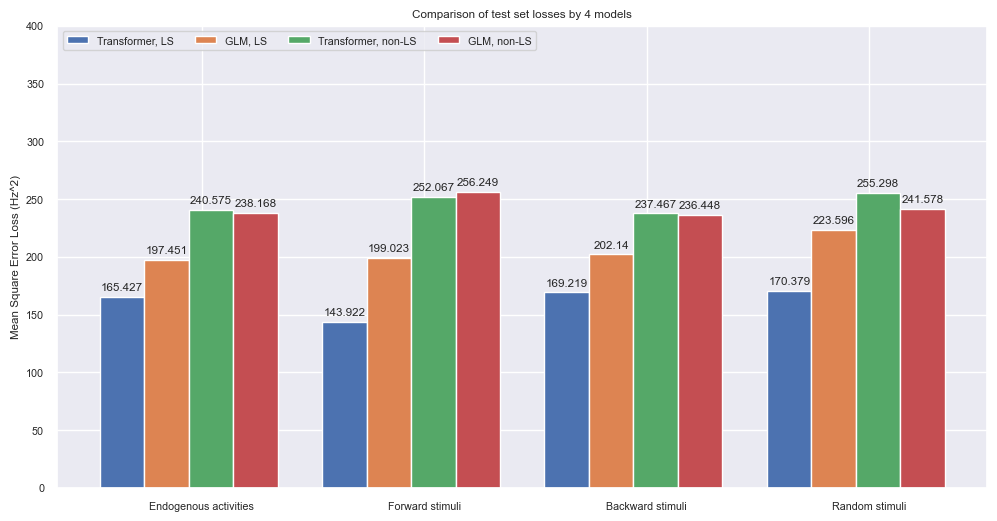

In [21]:
sns.set(font_scale=0.7)
stim_types = ['Endogenous activities', 'Forward stimuli', 'Backward stimuli', 'Random stimuli']
mses = {
    'Transformer, LS': (LS_test_pred_loss[non_stim_mse_idx].sum()/len(non_stim_mse_idx)/13,
                              LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/13,
                              LS_test_pred_loss[backward_mse_idx].sum()/len(backward_mse_idx)/13,
                              LS_test_pred_loss[random_mse_idx].sum()/len(random_mse_idx)/13),
    'GLM, LS': (glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/13,
                      glm_LS_losses[forward_mse_idx].sum() / len(forward_mse_idx)/13,
                      glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/13,
                      glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/13),
    'Transformer, non-LS': (nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
                                  nLS_test_pred_loss[forward_mse_idx].sum() / len(forward_mse_idx)/64,
                                  nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/64,
                                  nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/64),
    'GLM, non-LS': (glm_nLS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/64,
                          glm_nLS_losses[forward_mse_idx].sum() / len(forward_mse_idx)/64,
                          glm_nLS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/64,
                          glm_nLS_losses[random_mse_idx].sum() / len(random_mse_idx)/64)
}

x = np.arange(len(stim_types))
width = 0.2  # the width of the bars
multiplier = -0.8
fig, ax = plt.subplots(figsize=(12,6))

for model, loss in mses.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, loss, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Square Error Loss (Hz^2)')
ax.set_title('Comparison of test set losses by 4 models')
ax.set_xticks(x + width, stim_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 400)

plt.savefig('./figures/loss_bar_plot', bbox_inches='tight', dpi=350)
plt.show()


#### Violin plots

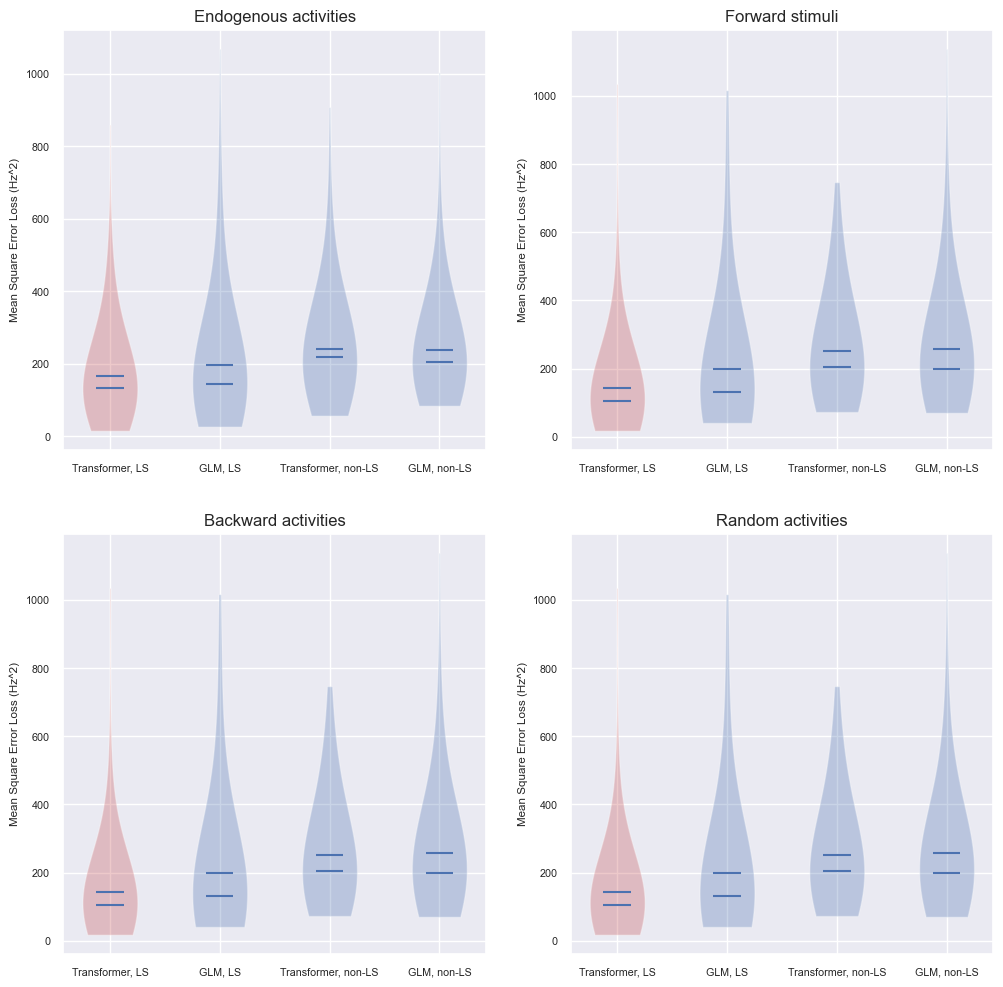

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
colors = ['r', 'b', 'b', 'b']

nstim_losses = [LS_test_pred_loss[non_stim_mse_idx].sum((1,2))/13, glm_LS_losses[non_stim_mse_idx]/13, nLS_test_pred_loss[non_stim_mse_idx].sum((1,2))/64, glm_nLS_losses[non_stim_mse_idx]/64]
vplots = axes[0,0].violinplot(nstim_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[0,0].set_xticks(np.arange(1,5), mses.keys())
axes[0,0].set_title('Endogenous activities', fontsize=12)
axes[0,0].set_ylabel('Mean Square Error Loss (Hz^2)')

forward_losses = [LS_test_pred_loss[forward_mse_idx].sum((1,2))/13, glm_LS_losses[forward_mse_idx]/13, nLS_test_pred_loss[forward_mse_idx].sum((1,2))/64, glm_nLS_losses[forward_mse_idx]/64]
vplots = axes[0,1].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[0,1].set_xticks(np.arange(1,5), mses.keys())
axes[0,1].set_title('Forward stimuli', fontsize=12)
axes[0,1].set_ylabel('Mean Square Error Loss (Hz^2)')


backward_losses = [LS_test_pred_loss[backward_mse_idx].sum((1,2))/13, glm_LS_losses[backward_mse_idx]/13, nLS_test_pred_loss[backward_mse_idx].sum((1,2))/64, glm_nLS_losses[backward_mse_idx]/64]
vplots = axes[1,0].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[1,0].set_xticks(np.arange(1,5), mses.keys())
axes[1,0].set_title('Backward activities', fontsize=12)
axes[1,0].set_ylabel('Mean Square Error Loss (Hz^2)')


random_losses = [LS_test_pred_loss[random_mse_idx].sum((1,2))/13, glm_LS_losses[random_mse_idx]/13, nLS_test_pred_loss[random_mse_idx].sum((1,2))/64, glm_nLS_losses[random_mse_idx]/64]
vplots = axes[1,1].violinplot(forward_losses, showextrema=False, showmeans=True, showmedians=True, bw_method=1)
for pc, c in zip(vplots['bodies'], colors):
    pc.set_facecolor(c)
axes[1,1].set_xticks(np.arange(1,5), mses.keys())
axes[1,1].set_title('Random activities', fontsize=12)
axes[1,1].set_ylabel('Mean Square Error Loss (Hz^2)')

plt.savefig('./figures/violin_loss_plot', bbox_inches='tight', dpi=350)
plt.show()


### ACF in GCaMP

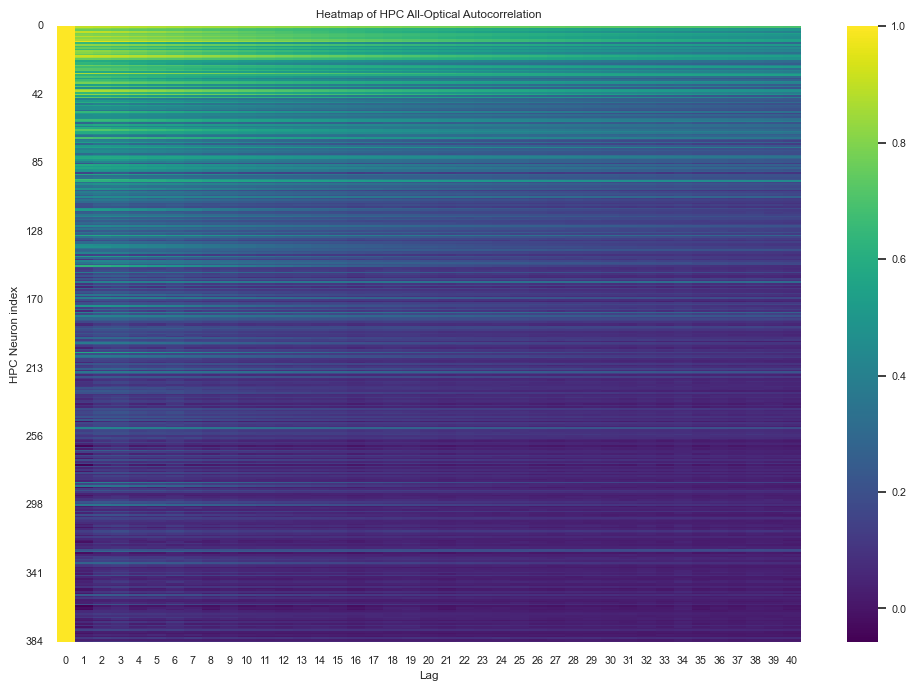

In [25]:
def compute_acf(data, lag=0):
    '''
    Data: shape (time_steps, dim)
    '''
    mean_ts = torch.mean(data, axis=0)
    var_ts = torch.var(data, axis=0)
    ts_len = data.shape[0]

    autocorr = np.zeros(data.shape[1])

    for i in range(data.shape[1]):
        if lag == 0:
            autocorr[i] = 1  # Autocorrelation at lag 0 is always 1
        else:
            autocorr[i] = torch.sum((data[:ts_len - lag, i] - mean_ts[i]) *
                                 (data[lag:, i] - mean_ts[i])) / (var_ts[i] * (ts_len - lag))
    return autocorr

img_array_acfs = np.array([compute_acf(img_array, lag=i) for i in range(0,41)]).T
plt.figure(figsize=(12, 8))
sns.heatmap(img_array_acfs, cmap='viridis')
plt.xlabel('Lag')
plt.yticks(np.linspace(0, img_array.shape[1], 10), map(int, np.linspace(0, img_array.shape[1], 10)))
plt.ylabel('HPC Neuron index')
plt.title('Heatmap of HPC All-Optical Autocorrelation')
plt.savefig('./figures/acf_img_array', bbox_inches='tight', dpi=350)
plt.show()

### Attention maps in the Encoder Layers

In [11]:
'''
NOTE BY DANIEL

In order to extract attention weights we need to tweak the torch source code.
Go to torch.nn.modules.transformer
and set all key worded arguments when forward-passing the MultiHeadAttention module
needs_weight False -> True
then attack the following hook
'''
def get_attention_hook(attention_weights_dict, layer_name):
    def hook(module, input, output):
        if len(output) == 2:
            attention_weights_dict[layer_name] = output[1].detach()
    return hook

attention_weights_dict = {}

for name, module in DNN_LS.named_modules():
    if isinstance(module, 
                  torch.nn.MultiheadAttention):
        hook = get_attention_hook(attention_weights_dict, name)
        module.register_forward_hook(hook)
        
with torch.no_grad():
    Y_test_nLS_hat = DNN_LS(X_test.permute(1,0,2).to(device))

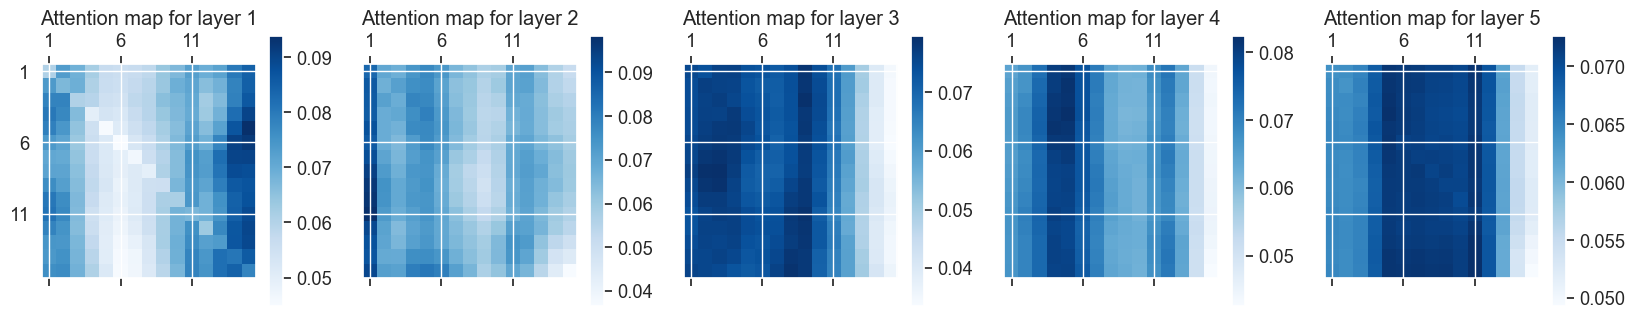

In [41]:
# plot average attention map for each layer

f, axes = plt.subplots(ncols=5, nrows=1, sharey=True, figsize=(20,5))
for layer, attn_w in enumerate(attention_weights_dict.values()):
    m = axes[layer].matshow(torch.mean(attn_w, dim=0).cpu().numpy(), cmap='Blues')
    f.colorbar(m, shrink=0.7)
    axes[layer].set_xticks(np.arange(0, 15, 5), np.arange(1, 16, 5))
    axes[layer].set_yticks(np.arange(0, 15, 5), np.arange(1, 16, 5))
    axes[layer].set_title(f'Attention map for layer {layer+1}')

plt.savefig('./figures/attn_maps', bbox_inches='tight', dpi=350)
plt.show()

### Optimal Prediction offset steps

In [ ]:
tsteps = 15
assert ephys_rates.shape[0] == img_array.shape[0]

n_vecs = int(ephys_rates.shape[0] / tsteps)
input_dim = img_array.shape[1]
output_dim = ephys_rates.shape[1]
n_vecs = int(ephys_rates.shape[0]/tsteps)
n_stims = len(stim_time)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(ephys_rates)
img_array = torch.as_tensor(img_array)

sweeplen = tsteps * 4
glm_loss_sweep = np.zeros((599, output_dim, sweeplen))

for s, loc in tqdm(enumerate(range(-4*tsteps, 4*tsteps, 1))):
    # begin sweep
    for n in range(2, n_vecs-2):
        inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
        targets[n,:,:] = ephys_rates[n*tsteps+loc:n*tsteps+loc+1,:]

    stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])
    non_stim_vecs_idx = [i for i in range(4, n_vecs-4) if i not in stim_vecs_idx] # exclude padding steps

    # exogenous as test dataset
    X_test, Y_test = inputs[stim_vecs_idx], targets[stim_vecs_idx]
    X, Y = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]

    from utils import randomise_dataset_split
    X_train, X_test_non_stim, X_valid, Y_train, Y_test_non_stim, Y_valid = randomise_dataset_split(X, Y, split_ratio=(0.85,0.05,0.1))
    X_test, Y_test = torch.vstack((X_test, X_test_non_stim)), torch.vstack((Y_test, Y_test_non_stim))
    
    # fit GLM
    X_train_np = X_train.cpu().numpy().reshape(X_train.shape[0],-1)
    Y_train_np = Y_train.cpu().numpy().reshape(Y_train.shape[0],-1) + 1e-6 # numerical stability

    X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
    Y_test_np = Y_test.cpu().numpy().reshape(Y_test.shape[0],-1) + 1e-6 # numerical stability

    from sklearn.linear_model import TweedieRegressor

    # pred for each neuron
    glm_losses = np.zeros(Y_test_np.shape[0])
    output_dim = Y_test_np.shape[1]

    for i in range(output_dim):
        glm_reg = TweedieRegressor(power=0, alpha=1, link='identity')
        glm_reg.fit(X_train_np, Y_train_np[:,i])
        
        R2_loss = np.power(Y_test_np[:,i] - glm_reg.predict(X_test_np), 2)
        glm_losses += R2_loss
        glm_loss_sweep[:, i, s] = R2_loss
    print(f'GLM with identity link function loss on step {s}: {glm_losses.sum() / Y_test.shape[0] / output_dim}')

0it [00:00, ?it/s]

1it [23:34, 1414.73s/it]

GLM with identity link function loss on step 0: 245.70398315098618


2it [46:20, 1385.81s/it]

GLM with identity link function loss on step 1: 245.24605700201286


3it [1:08:58, 1373.39s/it]

GLM with identity link function loss on step 2: 244.83554255367613


4it [1:31:18, 1359.88s/it]

GLM with identity link function loss on step 3: 244.46547041382533


5it [1:53:45, 1355.22s/it]

GLM with identity link function loss on step 4: 244.12879760924548


6it [2:16:45, 1363.82s/it]

GLM with identity link function loss on step 5: 243.75575028361015


7it [2:39:37, 1366.58s/it]

GLM with identity link function loss on step 6: 243.46629977815383


8it [3:02:24, 1366.56s/it]

GLM with identity link function loss on step 7: 243.19209418398017


9it [3:25:08, 1365.85s/it]

GLM with identity link function loss on step 8: 242.92954895157493


10it [3:49:43, 1399.51s/it]

GLM with identity link function loss on step 9: 242.67537223408735


11it [4:14:40, 1429.21s/it]

GLM with identity link function loss on step 10: 242.42739429458823


12it [4:39:29, 1447.43s/it]

GLM with identity link function loss on step 11: 242.18379738638995


13it [5:04:08, 1457.03s/it]

GLM with identity link function loss on step 12: 241.94261443034395


14it [5:28:38, 1460.98s/it]

GLM with identity link function loss on step 13: 241.701699956566


15it [5:52:24, 1450.43s/it]

GLM with identity link function loss on step 14: 241.45926339077707


16it [6:16:10, 1443.10s/it]

GLM with identity link function loss on step 15: 241.2133719882344


17it [6:40:07, 1441.30s/it]

GLM with identity link function loss on step 16: 240.96276056639473


18it [7:04:00, 1438.90s/it]

GLM with identity link function loss on step 17: 240.70711991600547


19it [7:28:02, 1439.79s/it]

GLM with identity link function loss on step 18: 240.44770897622342


20it [7:52:23, 1446.04s/it]

GLM with identity link function loss on step 19: 240.18776850715236


21it [8:17:39, 1467.10s/it]

GLM with identity link function loss on step 20: 239.91474948115422


22it [8:42:35, 1475.71s/it]

GLM with identity link function loss on step 21: 239.67121217168346


In [ ]:
# plot GLM loss wrt offset
plt.plot(glm_loss_sweep.sum(1).sum(0)/599/77)
plt.xticks(np.arange(0, tsteps * 4, 5), np.arange(- 2*tsteps, 2*tsteps, 5))
plt.xlabel('EPhys vs GCaMP Offset')
plt.ylabel('GLM R2 loss')
plt.show()